# ROI-based univariate analyses
Natalia Vélez, April 2022

In [18]:
%matplotlib inline

import os, sys
import pandas as pd
import numpy as np
from nilearn import image,plotting,masking
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join as opj
from scipy.io import loadmat
from scipy import stats

sys.path.append('..')
from utils import gsearch, str_extract

sns.set_style('white')
sns.set_context('talk')

## Setup

Valid subjects:

In [19]:
subjects = np.loadtxt('../1_preprocessing/outputs/valid_participants.txt', dtype=int)
print(subjects)

[ 1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26
 27 28 29 30]


Project directory:

In [20]:
data_dir = '/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives'
model_name = 'task-teaching_model-parametricnonortho'

Find ACC:

In [24]:
acc_file = '/ncf/gershman/User/nvelezalicea/fmri_analysis/roi_library/fmriprep_space/bilateral_ACCg.nii.gz'
os.path.exists(acc_file)

True

Find functional ROI files:

In [4]:
roi_files = gsearch(data_dir, 'roi_picker', 'sub-*', 'func', '*.nii.gz')
roi_files.sort()

print(f'Found {len(roi_files)} ROI files')
print(*roi_files[:10]+['...'], sep='\n')

Found 194 ROI files
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/roi_picker/sub-01/func/sub-01_task-tomloc_model-localizer_desc-DMPFC_mask.nii.gz
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/roi_picker/sub-01/func/sub-01_task-tomloc_model-localizer_desc-LTPJ_mask.nii.gz
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/roi_picker/sub-01/func/sub-01_task-tomloc_model-localizer_desc-MMPFC_mask.nii.gz
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/roi_picker/sub-01/func/sub-01_task-tomloc_model-localizer_desc-PC_mask.nii.gz
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/roi_picker/sub-01/func/sub-01_task-tomloc_model-localizer_desc-RSTS_mask.nii.gz
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/roi_picker/sub-01/func/sub-01_task-tomloc_model-localizer_desc-RTPJ_mask.nii.gz
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/roi_picker/sub-01/func/sub-01_task-tomloc_model-localizer_desc-VMPFC_mask.nii.gz
/n/ger

Find contrast files:

In [5]:
con_files = gsearch(data_dir, 'glm', 'sub-*', 'func', model_name, 'con*')
con_files.sort()

print(f'Found {len(con_files)} contrast files')
print(*con_files[:10]+['...'], sep='\n')

Found 56 contrast files
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-01/func/task-teaching_model-parametricnonortho/con_0001.nii
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-01/func/task-teaching_model-parametricnonortho/con_0002.nii
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-02/func/task-teaching_model-parametricnonortho/con_0001.nii
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-02/func/task-teaching_model-parametricnonortho/con_0002.nii
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-04/func/task-teaching_model-parametricnonortho/con_0001.nii
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-04/func/task-teaching_model-parametricnonortho/con_0002.nii
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-05/func/task-teaching_model-parametricnonortho/con_0001.nii
/n/gershman_ncf/Lab/natalia_teaching/BIDS_data/derivatives/glm/sub-05/func/task-teachin

Load contrast names:

In [6]:
con_file = opj(data_dir, 'glm', 'group', model_name, 'contrasts.mat')
con_data = loadmat(con_file)
contrasts_raw = con_data['contrasts']
contrasts = [c[0].replace('+', '') for c in contrasts_raw[0]] # all a hacky way of reading mat files
print(f'Found {len(contrasts)} contrasts')
print(*contrasts, sep='\n')

Found 2 contrasts
pTrue
KL


## First-level contrasts

Main loop: Extract data from all ROIs

In [25]:
# Initialize output
roi_list = []

# Iterate over subjects and contrasts
for sub in subjects:
    for con_idx,con_name in enumerate(contrasts):
        
        # Format subject, contrast numbers nicely
        sub_id = 'sub-%02d' % sub
        con_id = 'con_%04d' % (con_idx+1)

        # Filter out contrast, ROI files
        sub_con = [f for f in con_files if sub_id in f and con_id in f]
        sub_con = sub_con[0] # should be a unique file

        sub_roi = [f for f in roi_files if sub_id in f]
        sub_roi.append(acc_file) # add anatomical ACC ROI
        sub_roi.sort() # list of files
                
        # Extract average t from each ROI
        for roi in sub_roi:
            roi_name = str_extract('(?<=desc-)[A-Za-z]+|ACC', roi)            
            masked_t = masking.apply_mask(sub_con, roi)
            mean_t = masked_t.mean()
            
            roi_list.append((sub, con_name, roi_name, mean_t))

In [36]:
# put it all together
roi_df = pd.DataFrame(roi_list, columns=['subject', 'contrast', 'roi', 'beta'])
roi_df['roi'] = roi_df.roi.astype('category')
roi_df = roi_df.sort_values(by=['subject', 'contrast', 'roi']).reset_index(drop=True)
print(roi_df.shape)
roi_df.head(8)

(444, 4)


,subject,contrast,roi,beta
0,1,KL,ACC,-0.626516
1,1,KL,DMPFC,-1.969529
2,1,KL,LTPJ,-0.848435
3,1,KL,MMPFC,-2.737912
4,1,KL,PC,0.074017
5,1,KL,RSTS,-0.502409
6,1,KL,RTPJ,-0.197082
7,1,KL,VMPFC,-1.147558


Do one-sample t-tests with Bonferroni correction:

In [37]:
t_list = []

# do one-sample t-tests on average ROI betas
for name,group in roi_df.groupby(['roi', 'contrast']):
    # find CI (for plotting)
    ci_lo, ci_hi = sns.utils.ci(sns.algorithms.bootstrap(group.beta))
    group_mean = group.beta.mean()
    
    res = stats.ttest_1samp(group.beta, 0)
    t_list.append(name+(group_mean, res.statistic, res.pvalue, ci_lo, ci_hi))
    
t_df = (
    pd.DataFrame(t_list, columns=['roi', 'contrast', 'avg', 'statistic', 'pvalue', 'ci_lo', 'ci_hi'])
    .sort_values(by=['contrast', 'roi'])
    .reset_index(drop=True)
)
t_df['roi'] = t_df['roi'].astype('category')

# mark ROIs that survive Bonferroni correction
p_thresh = 0.05/(t_df.roi.nunique()+1)
t_df['sig'] = np.where(t_df.pvalue < p_thresh, '*', '') # extra vars for plotting
t_df['sig_y'] = np.where(t_df.avg >= 0, t_df.ci_hi+.1, t_df.ci_lo-.3)
t_df['sig_x'] = t_df.roi.cat.codes-.11

t_df

,roi,contrast,avg,statistic,pvalue,ci_lo,ci_hi,sig,sig_y,sig_x
0,ACC,KL,-0.244126,-2.844336,8.384828e-03,-0.403815,-0.075808,,-0.703815,-0.11
1,DMPFC,KL,-1.583869,-6.792981,2.696703e-07,-2.037975,-1.124335,*,-2.337975,0.89
2,LTPJ,KL,-0.553515,-3.519281,1.554426e-03,-0.858619,-0.242087,*,-1.158619,1.89
3,MMPFC,KL,-2.138596,-10.265689,1.224605e-10,-2.542948,-1.732783,*,-2.842948,2.89
4,PC,KL,-0.129469,-0.782214,4.408955e-01,-0.439754,0.192725,,-0.739754,3.89
5,RSTS,KL,-0.474729,-4.676338,7.268860e-05,-0.671725,-0.281268,*,-0.971725,4.89
6,RTPJ,KL,-0.291113,-1.820868,7.972761e-02,-0.599715,0.011940,,-0.899715,5.89
7,VMPFC,KL,-1.348541,-6.415155,8.510891e-07,-1.762238,-0.951832,*,-2.062238,6.89
8,ACC,pTrue,0.418553,2.844035,8.390893e-03,0.146155,0.709594,,0.809594,-0.11
9,DMPFC,pTrue,2.066409,3.798998,7.513888e-04,1.040130,3.134362,*,3.234362,0.89


### 1) Posterior probability of true hypothesis

Plot results:

[Text(0.5, 0, ''),
 Text(0, 0.5, 'Beta'),
 Text(0.5, 1.0, 'Belief in true hypothesis: $P_L(h_T|d)$'),
 (-0.4577575102199002, 5.310290266889043)]

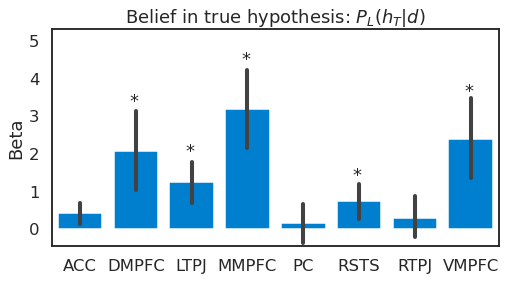

In [41]:
pTrue_df = roi_df[roi_df.contrast == 'pTrue']
fig,ax = plt.subplots(figsize=(8,4))
sns.barplot(data=pTrue_df, x='roi', y='beta', fc='#007fcf', ax=ax)

pTrue_sig = t_df[t_df.contrast == 'pTrue']
for _, row in pTrue_sig.iterrows():
    ax.text(row.sig_x, row.sig_y, row.sig)

ax.set(xlabel='', ylabel='Beta', title = r'Belief in true hypothesis: $P_L(h_T|d)$', ylim=(
    pTrue_sig.ci_lo.min()*1.25,
    pTrue_sig.ci_hi.max()*1.25
))

### 2) Belief update

[Text(0.5, 0, ''),
 Text(0, 0.5, 'Beta'),
 Text(0.5, 1.0, 'Belief update (KL divergence)'),
 (-3.1786846420468966, 0.24090590732937145)]

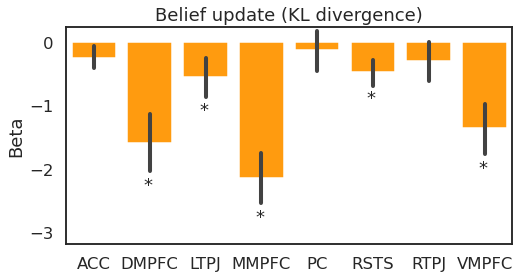

In [42]:
KL_df = roi_df[roi_df.contrast == 'KL']
fig,ax = plt.subplots(figsize=(8,4))
sns.barplot(data=KL_df, x='roi', y='beta', fc='#ff9b0f', ax=ax)

KL_sig = t_df[t_df.contrast == 'KL']
for _, row in KL_sig.iterrows():
    ax.text(row.sig_x, row.sig_y, row.sig)

ax.set(xlabel='', ylabel='Beta', title = 'Belief update (KL divergence)', ylim=(
    KL_sig.ci_lo.min()*1.25,
    KL_sig.ci_hi.max()*1.25
))

## Second-level contrasts

Load participant-specific predictors:

In [43]:
sub_models = pd.read_csv('../2_behavioral/outputs/second_level_model_regressors.csv')
sub_models.head()

,subject,logBF
0,1,-0.897386
1,2,-1.037389
2,4,2.297325
3,5,-0.636657
4,6,-0.963019


Merge with subject-specific betas:

In [44]:
second_level = roi_df.merge(sub_models)
second_level.head()

,subject,contrast,roi,beta,logBF
0,1,KL,ACC,-0.626516,-0.897386
1,1,KL,DMPFC,-1.969529,-0.897386
2,1,KL,LTPJ,-0.848435,-0.897386
3,1,KL,MMPFC,-2.737912,-0.897386
4,1,KL,PC,0.074017,-0.897386


### 1) Posterior probability of true hypothesis

Plot second-order relationships:

Text(0.5, 0.98, 'Belief in true hypothesis: $P_L(h_T|d)$')

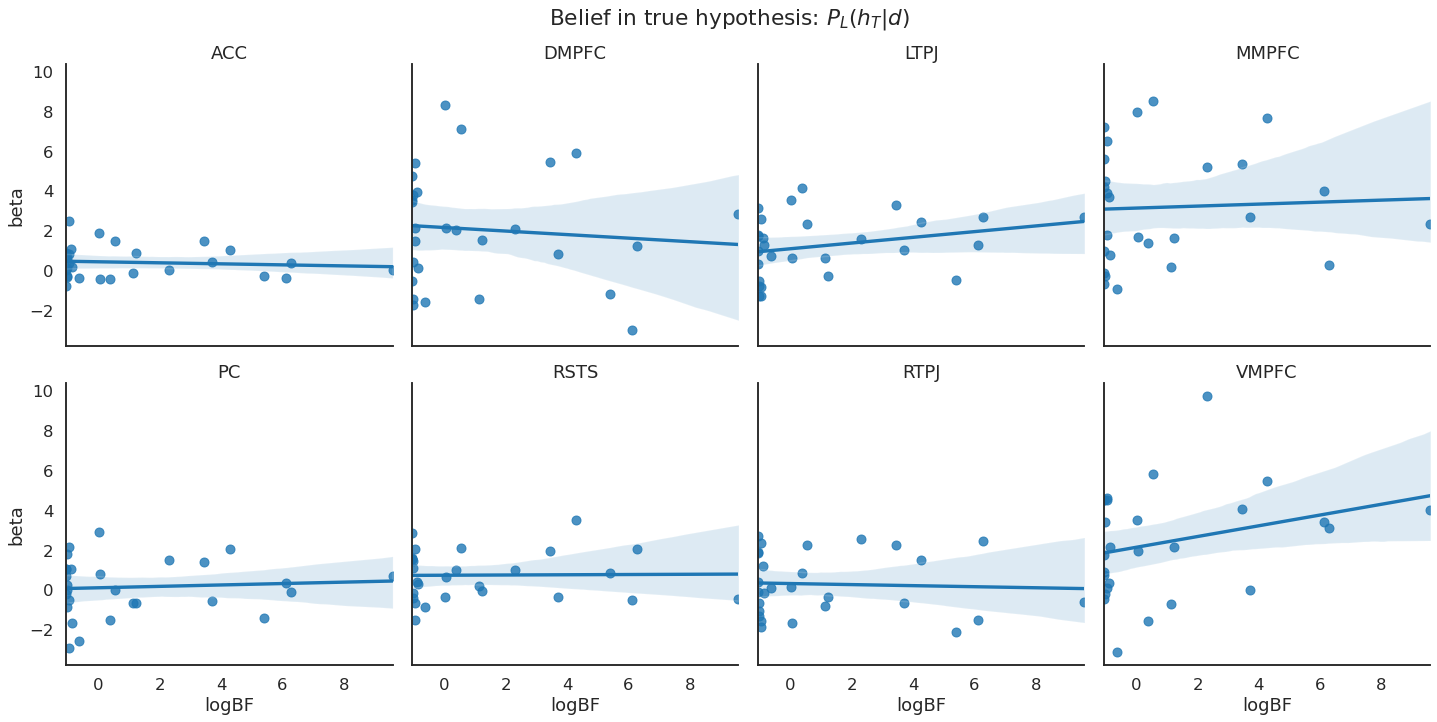

In [45]:
second_pTrue = second_level[second_level.contrast == 'pTrue']

g = sns.lmplot(data=second_pTrue, x="logBF", y="beta", col="roi", col_wrap=4)
g.set_titles('{col_name}')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle(r'Belief in true hypothesis: $P_L(h_T|d)$')

Correlation tests:

In [46]:
pTrue_corr_list = []
for name,group in second_pTrue.groupby('roi'):
    r,p = stats.pearsonr(group.logBF, group.beta)
    pTrue_corr_list.append((name, r, p))
    
pTrue_corr = pd.DataFrame(pTrue_corr_list, columns=['roi', 'correlation', 'pvalue'])
pTrue_corr

,roi,correlation,pvalue
0,ACC,-0.096273,0.626018
1,DMPFC,-0.089949,0.648972
2,LTPJ,0.274555,0.157387
3,MMPFC,0.049918,0.804707
4,PC,0.073291,0.710909
5,RSTS,0.014367,0.942155
6,RTPJ,-0.049775,0.801403
7,VMPFC,0.281396,0.155052


### 2) Belief update

Plot second-order relationships:

Text(0.5, 0.98, 'Belief update (KL divergence)')

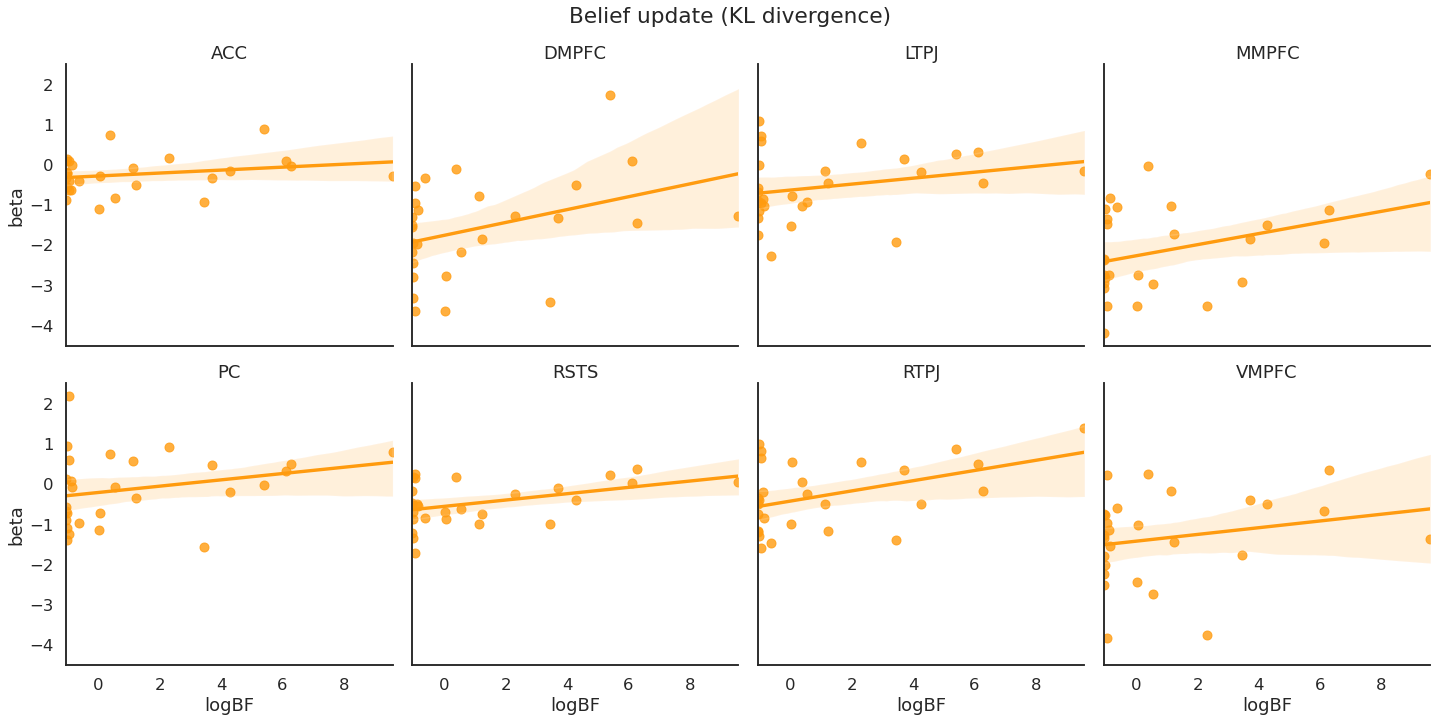

In [48]:
second_KL = second_level[second_level.contrast == 'KL']

g = sns.lmplot(data=second_KL, x="logBF", y="beta", col="roi", col_wrap=4, scatter_kws={'color':'#ff9b0f'}, line_kws={'color':'#ff9b0f'})
g.set_titles('{col_name}')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Belief update (KL divergence)')

Correlation tests:

In [49]:
KL_corr_list = []
for name,group in second_KL.groupby('roi'):
    r,p = stats.pearsonr(group.logBF, group.beta)
    KL_corr_list.append((name, r, p))
    
KL_corr = pd.DataFrame(KL_corr_list, columns=['roi', 'correlation', 'pvalue'])
KL_corr

,roi,correlation,pvalue
0,ACC,0.234945,0.228796
1,DMPFC,0.377602,0.047590
2,LTPJ,0.259401,0.182535
3,MMPFC,0.363207,0.062582
4,PC,0.261194,0.179422
5,RSTS,0.426907,0.023472
6,RTPJ,0.437051,0.020042
7,VMPFC,0.218414,0.273740
